<a href="https://colab.research.google.com/github/naenumtou/deepLearning/blob/main/LSTMStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To using Yahoo finance instead of pandas datareader
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.63)


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization

# Checking GPU available
if tf.test.gpu_device_name() == '/device:GPU:0':
  print('GPU is available')
else:
  print('GPU is not available')

# Config display
%config InlineBackend.figure_format = 'retina'

GPU is available


In [3]:
# Get Stock data
df = yf.download('PTT.BK', start = '2012-01-01', end = '2020-12-31')
df.head(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-04,32.299999,32.500000,32.200001,32.400002,22.488480,39899000
2012-01-05,32.400002,32.799999,32.299999,32.799999,22.766115,42206000
2012-01-06,32.700001,32.700001,32.200001,32.299999,22.419069,23963000
2012-01-09,32.200001,32.500000,32.099998,32.400002,22.488480,33054000
2012-01-10,32.400002,32.700001,32.299999,32.400002,22.488480,58131000


In [4]:
# Keep only 'Adj Close' field
df = df[['Adj Close']]
df.describe()

,Adj Close
count,2197.000000
mean,31.341758
std,8.755331
min,16.028448
25%,23.907255
50%,28.163761
75%,39.280975
max,52.532326


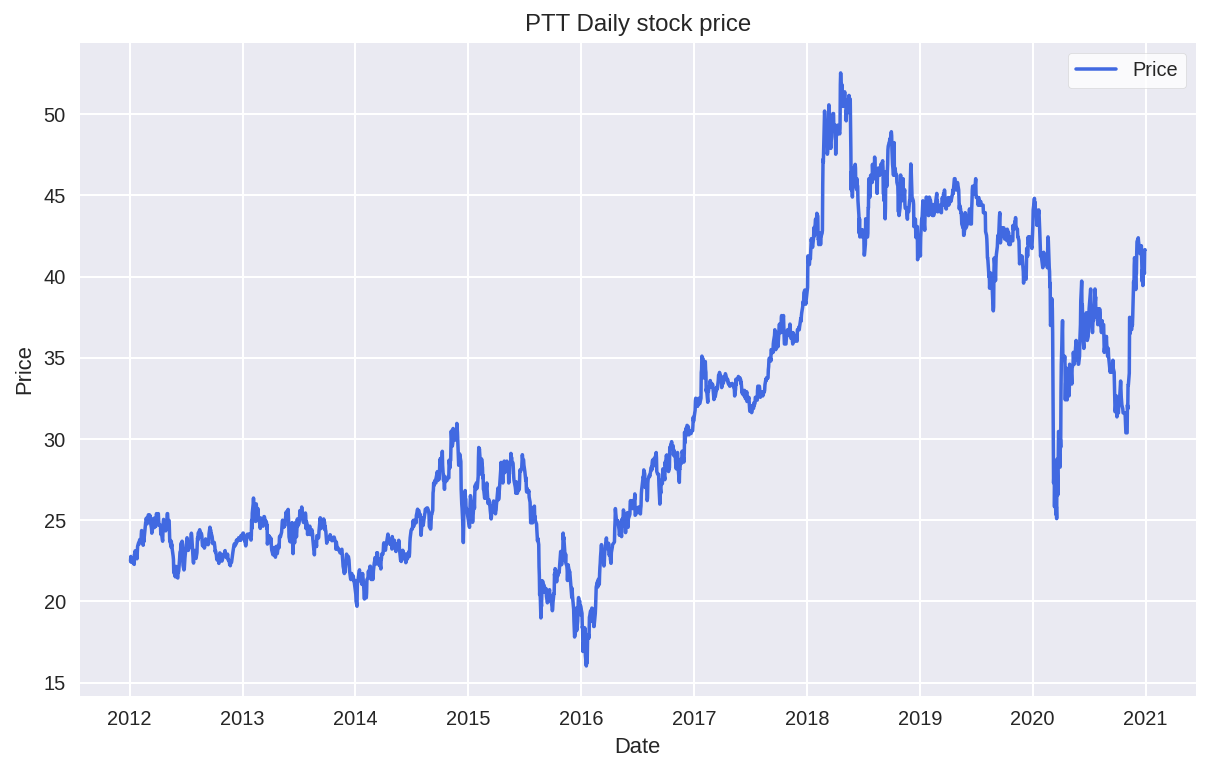

In [5]:
# Plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('PTT Daily stock price')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.plot(df, c = 'royalblue', label = 'Price')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

In [6]:
# Split data for validation
valPortion = 0.1 #10% for validation
train = df.iloc[0:int(df.shape[0] * (1 - valPortion))].copy(deep = True)
test = df.iloc[int(df.shape[0] * (1 - valPortion)):].copy(deep = True)

In [7]:
# Normalised data
scaler = MinMaxScaler() #Transformed data to be (0-1)
scaler.fit(train)
trainScale = pd.DataFrame(scaler.transform(train), columns = train.columns)
testScale = pd.DataFrame(scaler.transform(test), columns = test.columns) #Using train scaler

In [8]:
# Create sequential data
def sequentialData(data, rangeDay):
  X = []
  y = []
  data = data.values
  for sequent in range(len(data) - rangeDay):
    X.append(data[sequent:sequent + rangeDay])
    y.append(data[sequent + rangeDay])
  return np.array(X), np.array(y)

XTrain, yTrain = sequentialData(trainScale, 5) #Lag 5 days to predict future
XTest, yTest = sequentialData(testScale, 5)
print(f'Train features shape: {XTrain.shape}')
print(f'Train target shape: {yTrain.shape}')
print(f'Test features shape: {XTest.shape}')
print(f'Test target shape: {yTest.shape}')

Train features shape: (1972, 5, 1)
Train target shape: (1972, 1)
Test features shape: (215, 5, 1)
Test target shape: (215, 1)


In [9]:
# LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape = (XTrain.shape[1:]), return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1)) #Output layer

# Defining the optimizer
optz = tf.keras.optimizers.Adam(learning_rate = 0.001)

# Complie the model
model.compile(loss = 'mse', optimizer = optz)

# Model overview
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            66560     
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 256)            394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 256)            1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               1

In [10]:
# Fitting LSTM Model
logs = model.fit(XTrain, yTrain, batch_size = 64, epochs = 100, validation_data = (XTest, yTest))

Epoch 1/100
31/31 [==============================] - 15s 125ms/step - loss: 0.3626 - val_loss: 0.2874
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 0.1122 - val_loss: 0.2390
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0745 - val_loss: 0.2022
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0585 - val_loss: 0.1511
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 0.0505 - val_loss: 0.1356
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0385 - val_loss: 0.1182
Epoch 7/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0349 - val_loss: 0.1114
Epoch 8/100
31/31 [==============================] - 1s 24ms/step - loss: 0.0302 - val_loss: 0.1080
Epoch 9/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0247 - val_loss: 0.0951
Epoch 10/100
31/31 [==============================] - 1s 23ms/step - loss: 0.0222 - val_loss: 0.09

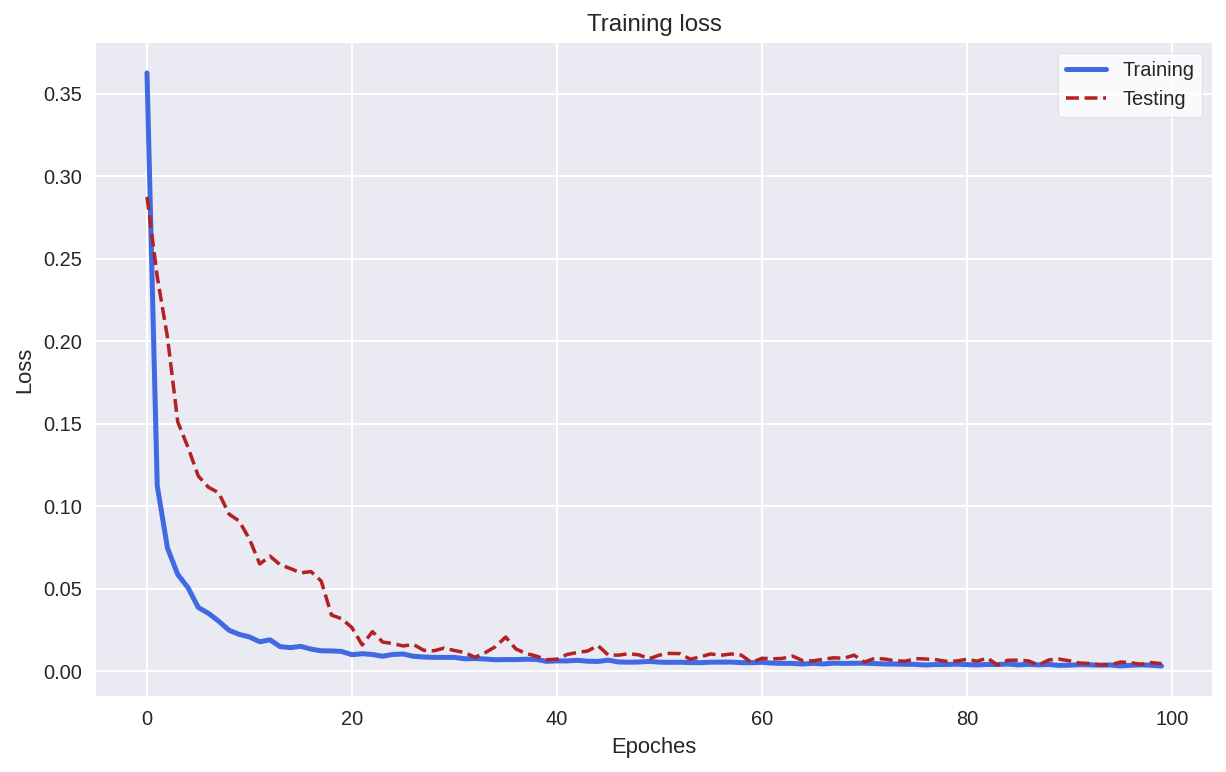

In [11]:
# Plot loss function
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Training loss')
  plt.xlabel('Epoches')
  plt.ylabel('Loss')
  plt.plot(logs.history['loss'], c = 'royalblue', linewidth = 2.5, label = 'Training')
  plt.plot(logs.history['val_loss'], c = 'firebrick', linestyle = '--', label = 'Testing')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()

In [12]:
# Model performance
print(f'MSE: {mean_squared_error(yTrain, model.predict(XTrain).reshape(-1)) * 100:.2f}%') #Train
print(f'MSE: {mean_squared_error(yTest, model.predict(XTest).reshape(-1)) * 100:.2f}%') #Test

MSE: 0.30%
MSE: 0.45%


In [13]:
# Create function for testing
def modelTesting(X, y, dataIndex, plotName):

  # Model prediction
  yPred = model.predict(X)
  yPred = scaler.inverse_transform(yPred)

  # Create dataframe
  data = pd.DataFrame(yPred.flatten(), columns = ['Predict']) 
  data['Actual'] = scaler.inverse_transform(y).flatten()
  data.index = dataIndex.index[5:] #Leave first 5 days for sequential

  # Plot
  plt.figure(figsize = (10, 6))
  with plt.style.context('seaborn'):
    plt.title(plotName)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(data['Actual'], c = 'royalblue', linewidth = 1.5, label = 'Actual') #Inverse scaler
    plt.plot(data['Predict'], c = 'firebrick', linestyle = '--', label = 'Predict')
    plt.xticks(rotation = 45)
    plt.legend(frameon = True, facecolor = 'white')
  return plt.show()

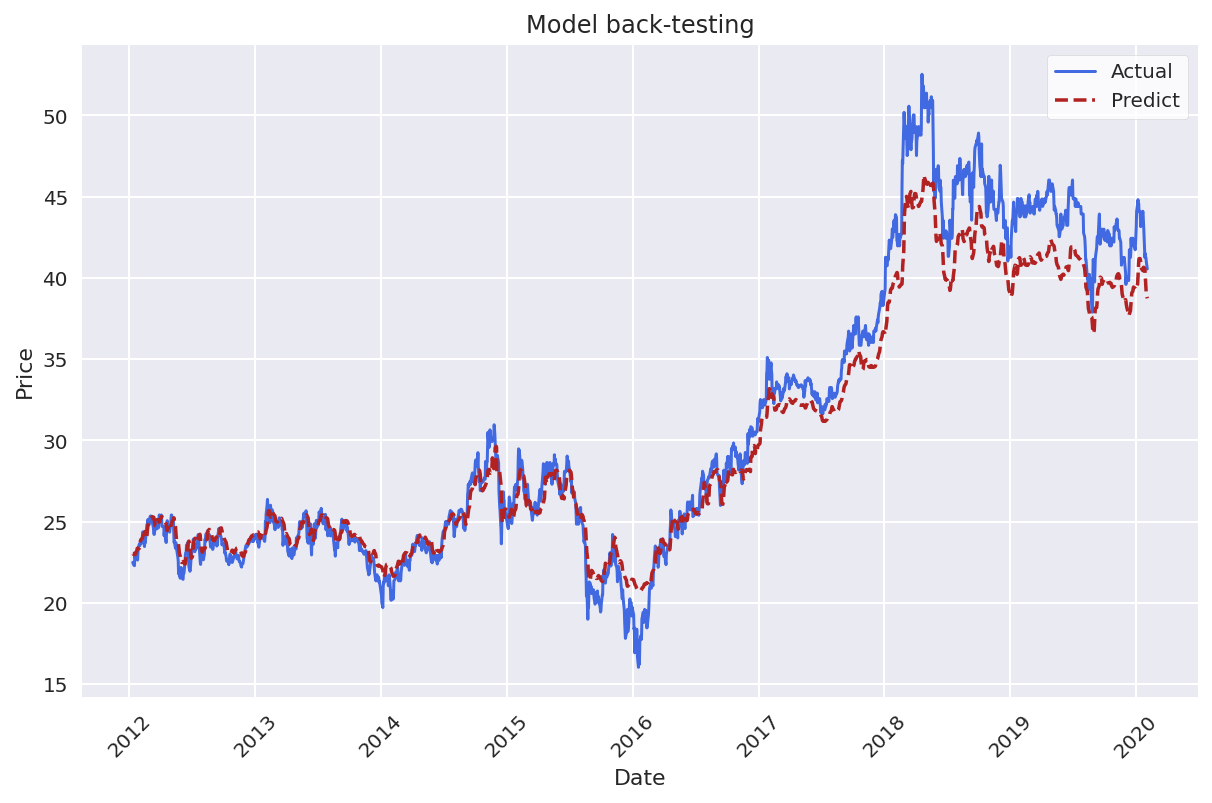

In [14]:
# Model back-testing
modelTesting(XTrain, yTrain, train, 'Model back-testing')

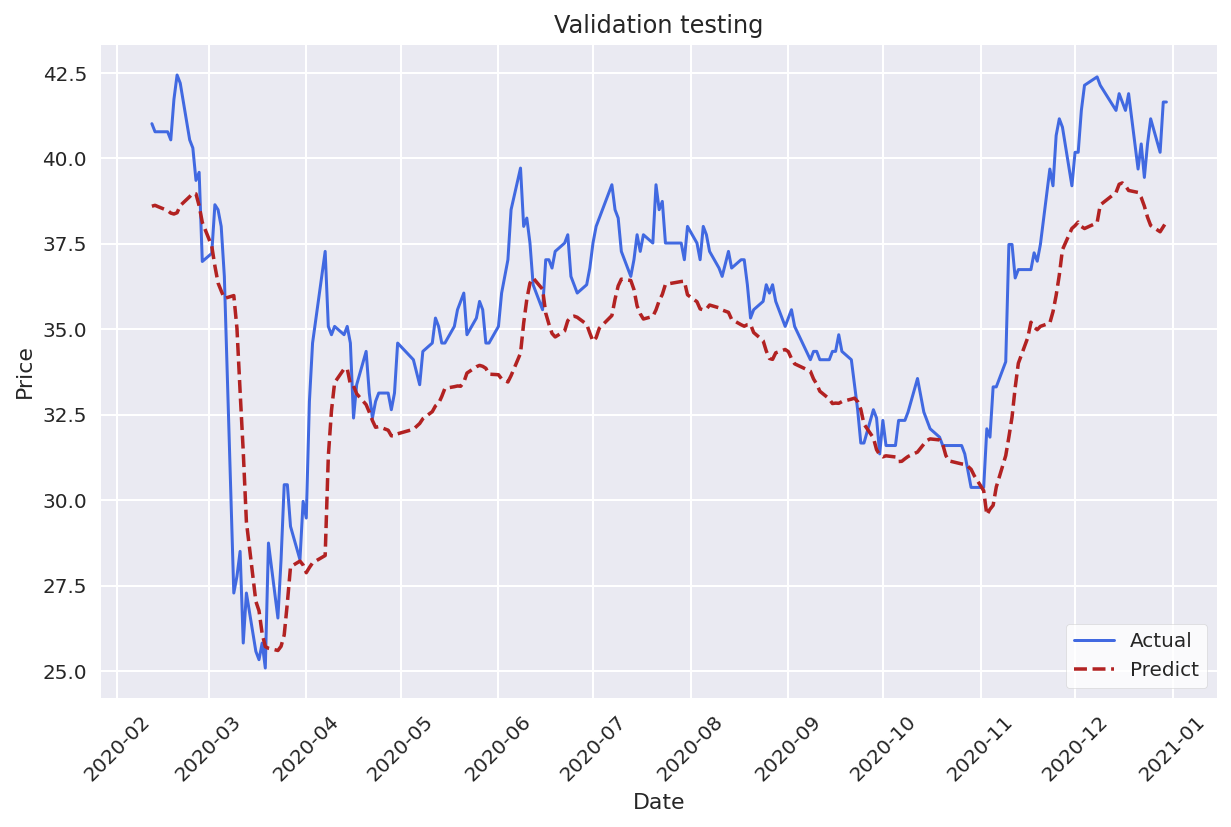

In [15]:
# Model validation
modelTesting(XTest, yTest, test, 'Validation testing')

In [16]:
# Out of time
# Get stock price for year 2021
outSet = yf.download('PTT.BK', start = '2021-01-01', end = '2021-06-30') #Using first half year for prediction

# Data preprocessing
# Keep only 'Adj Close' field
outSet = outSet[['Adj Close']]

# Normalised data
outScale = pd.DataFrame(scaler.transform(outSet), columns = outSet.columns)

# Create sequential data
XOut, yOut = sequentialData(outScale, 5)
print(f'Out of time features shape: {XOut.shape}')
print(f'Out of time target shape: {yOut.shape}')

[*********************100%***********************]  1 of 1 completed
Out of time features shape: (112, 5, 1)
Out of time target shape: (112, 1)


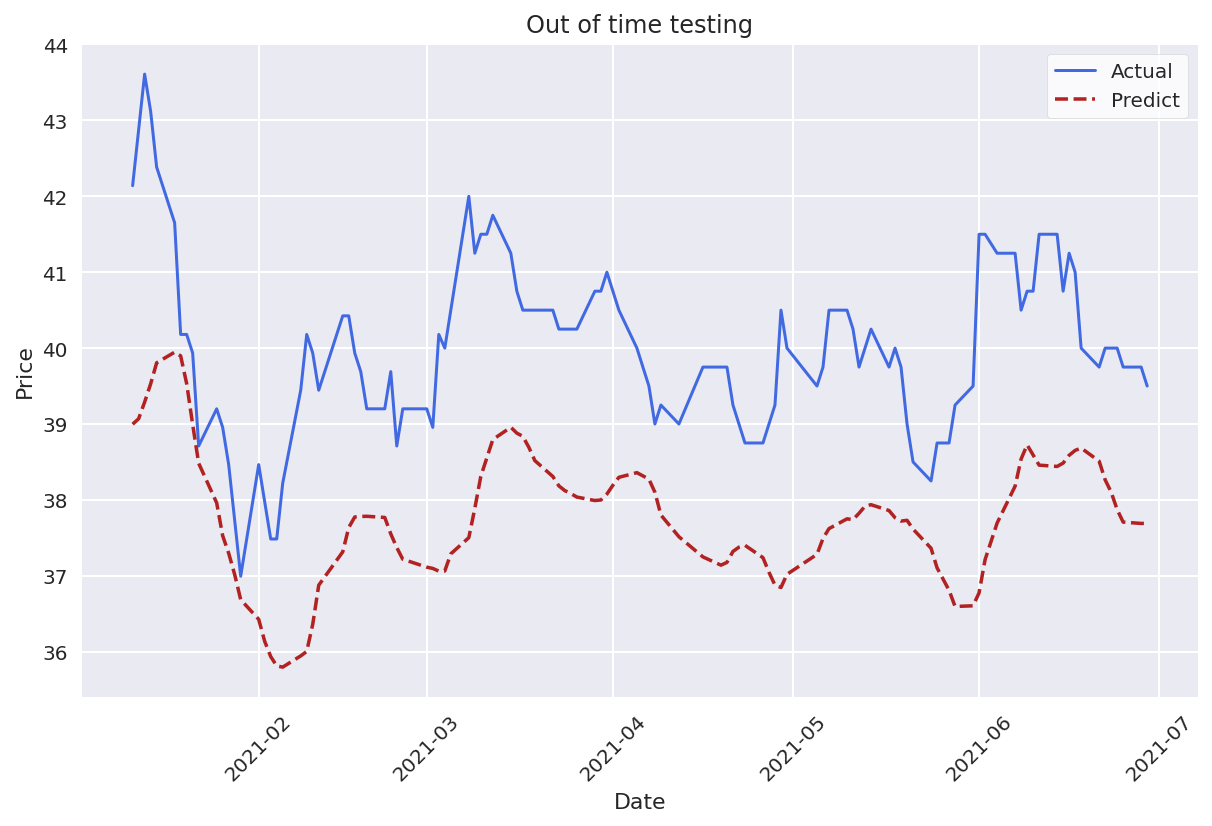

In [17]:
# Out of time testing
modelTesting(XOut, yOut, outSet, 'Out of time testing')